In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

import matplotlib.pyplot as plt


In [ ]:

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
        
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

model.train()
mse_per_epoch = []

for epoch in tqdm(range(1000)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat - snapshot.y) ** 2)
    cost = cost / (time + 1)
    mse_per_epoch.append(cost.item())  # Store cost at each iteration
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Final train cost: {:.4f}".format(cost.item()))

    
model.eval()
cost = 0
mse 
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))


 22%|██▏       | 224/1000 [00:09<00:34, 22.67it/s]

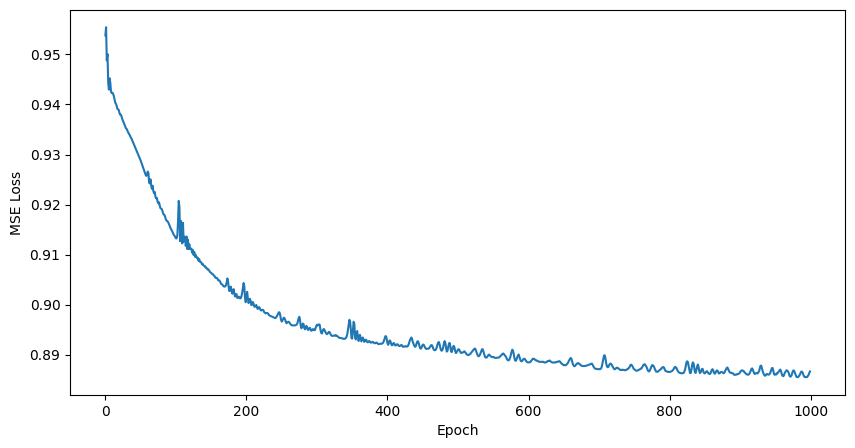

In [ ]:
# plot mse loss per epoch
plt.figure(figsize=(10,5))
plt.plot(range(len(mse_per_epoch)), mse_per_epoch)
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.show()


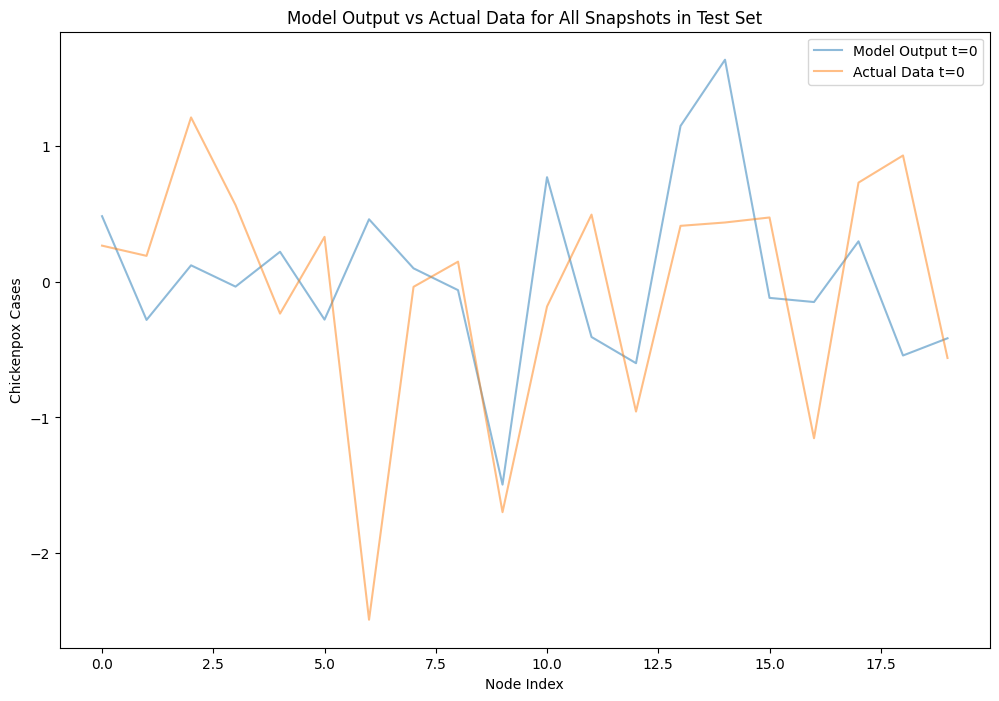

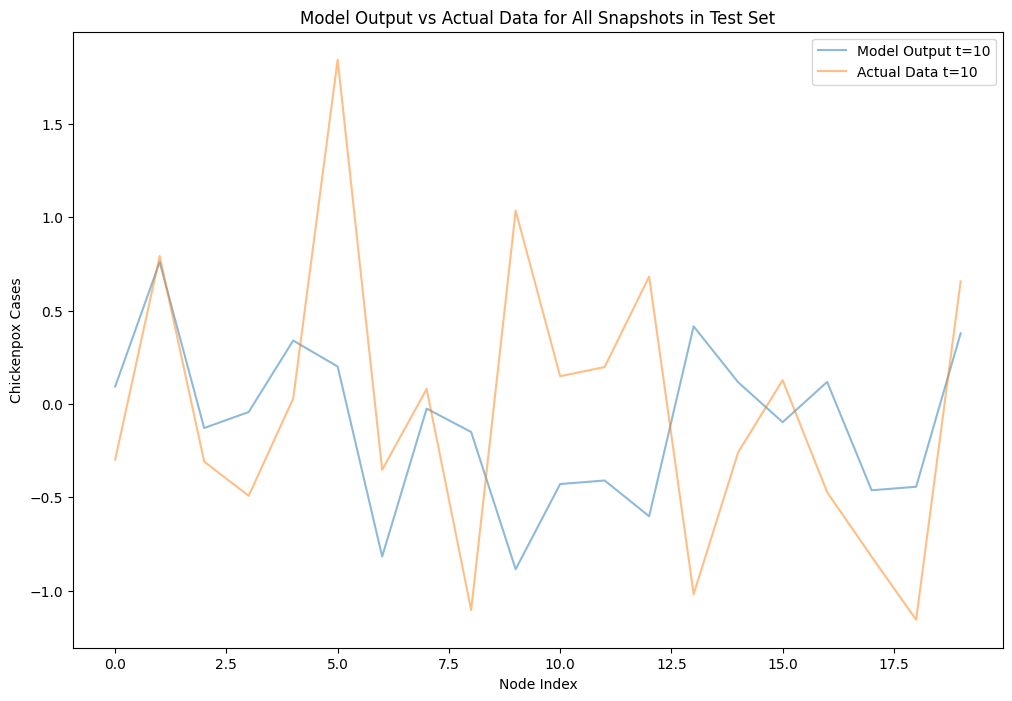

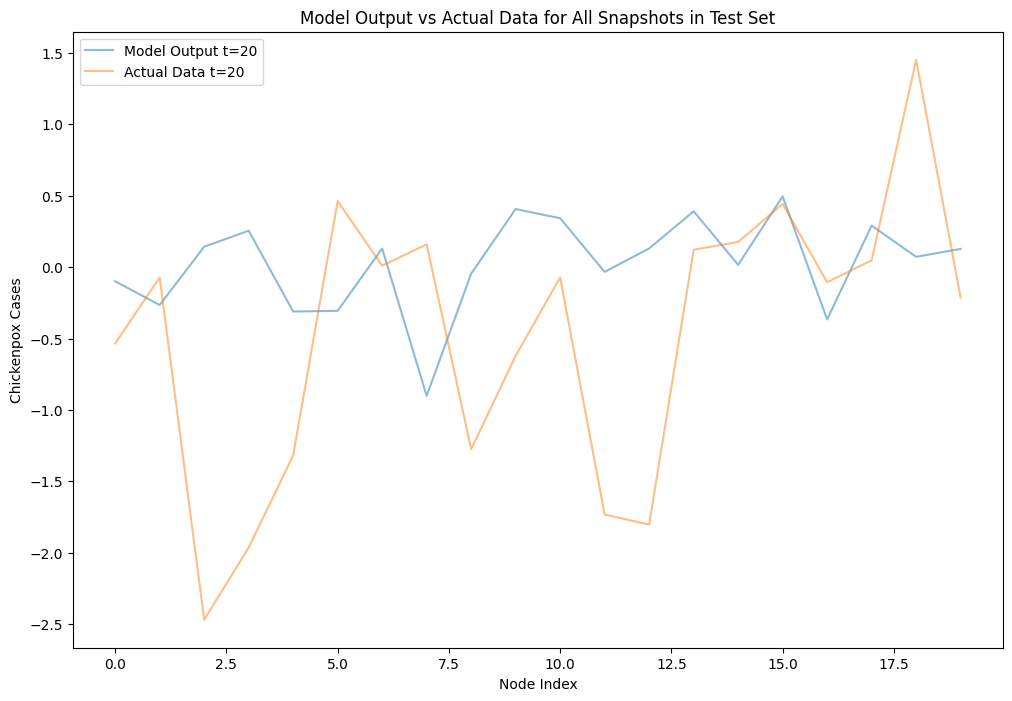

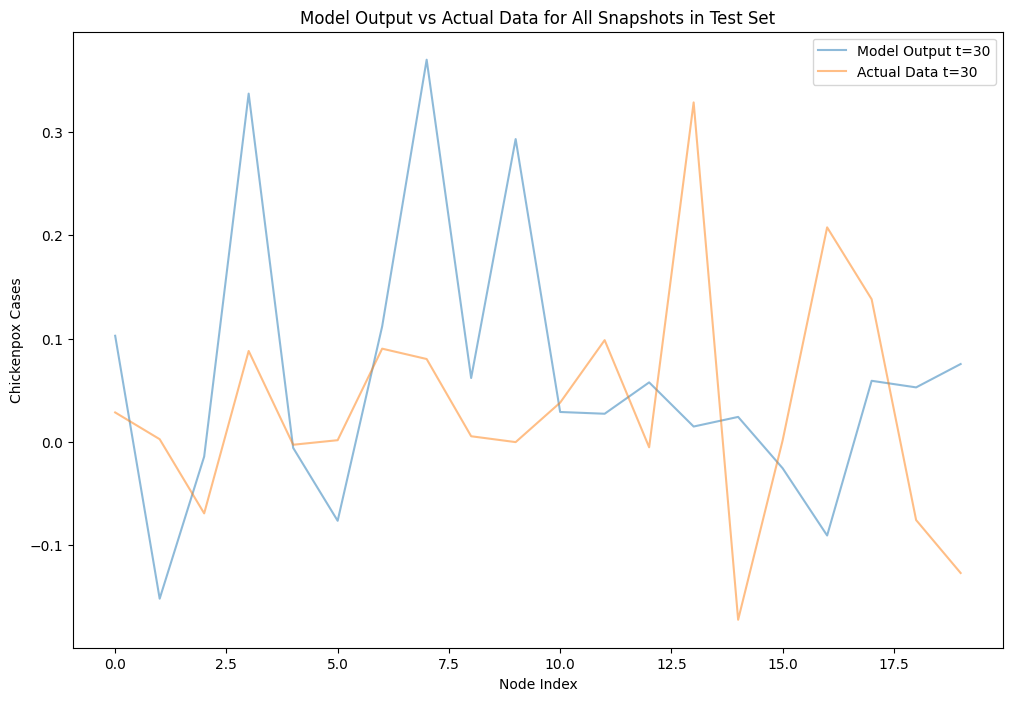

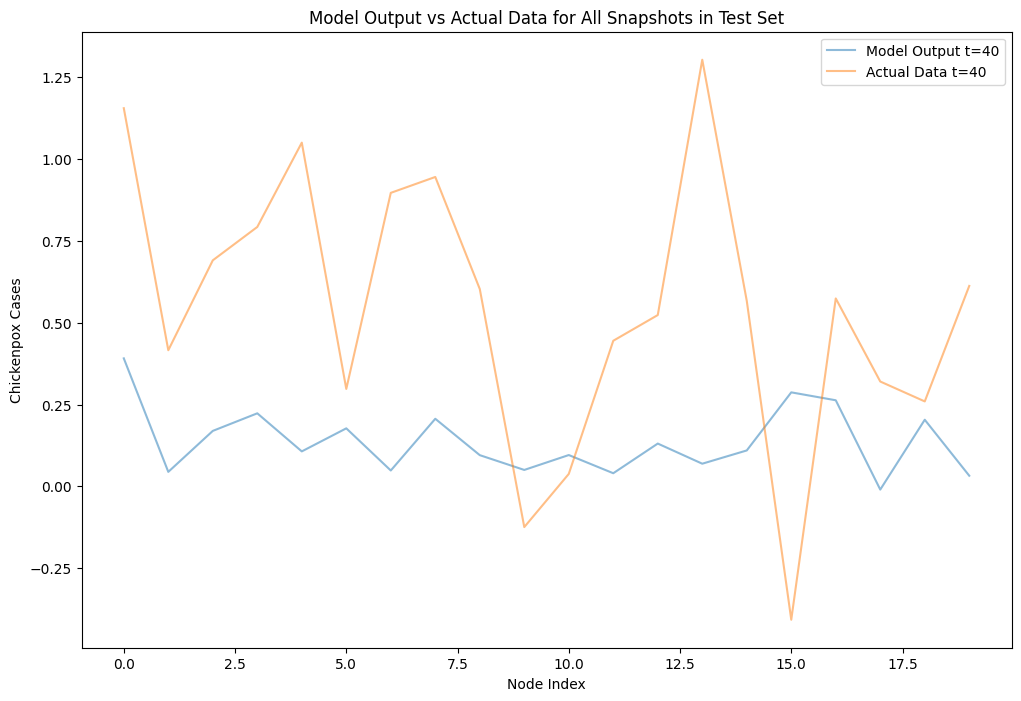

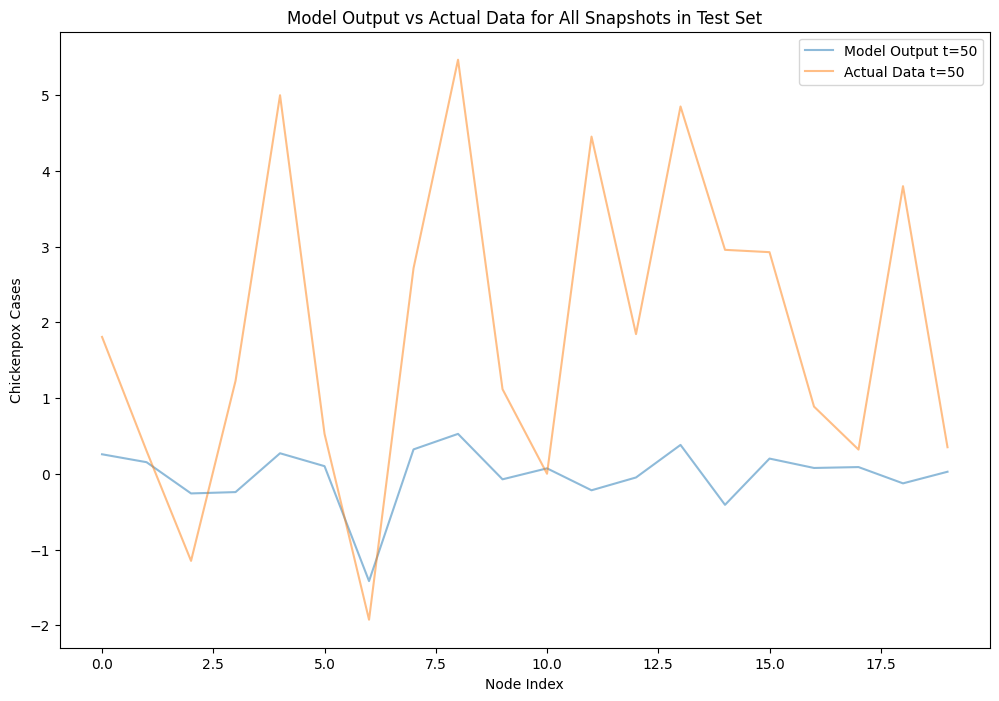

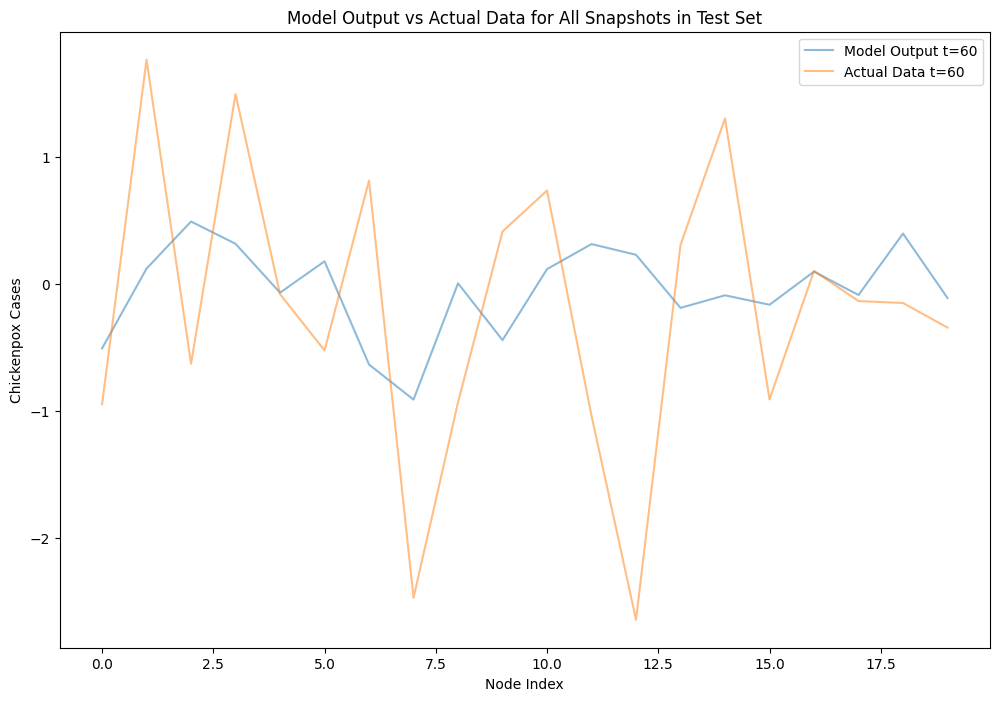

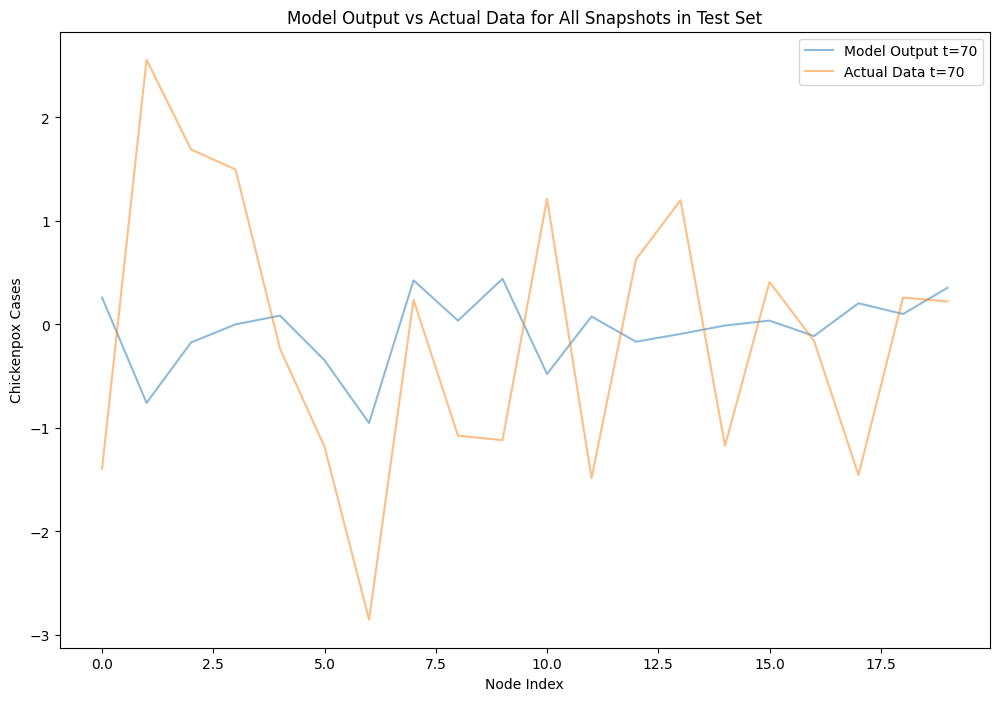

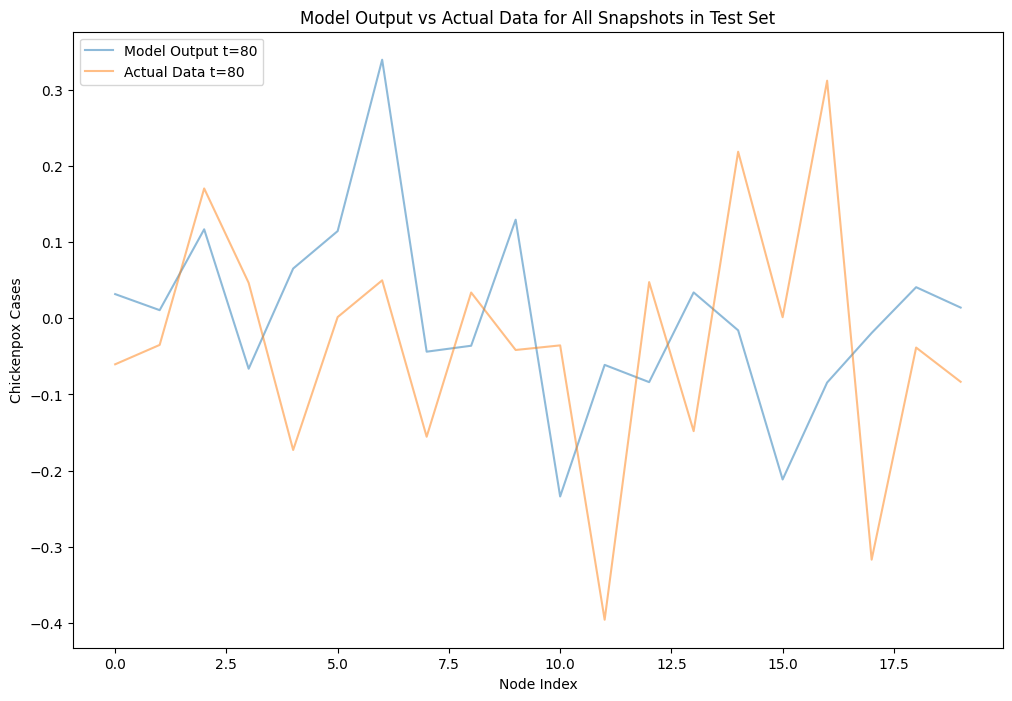

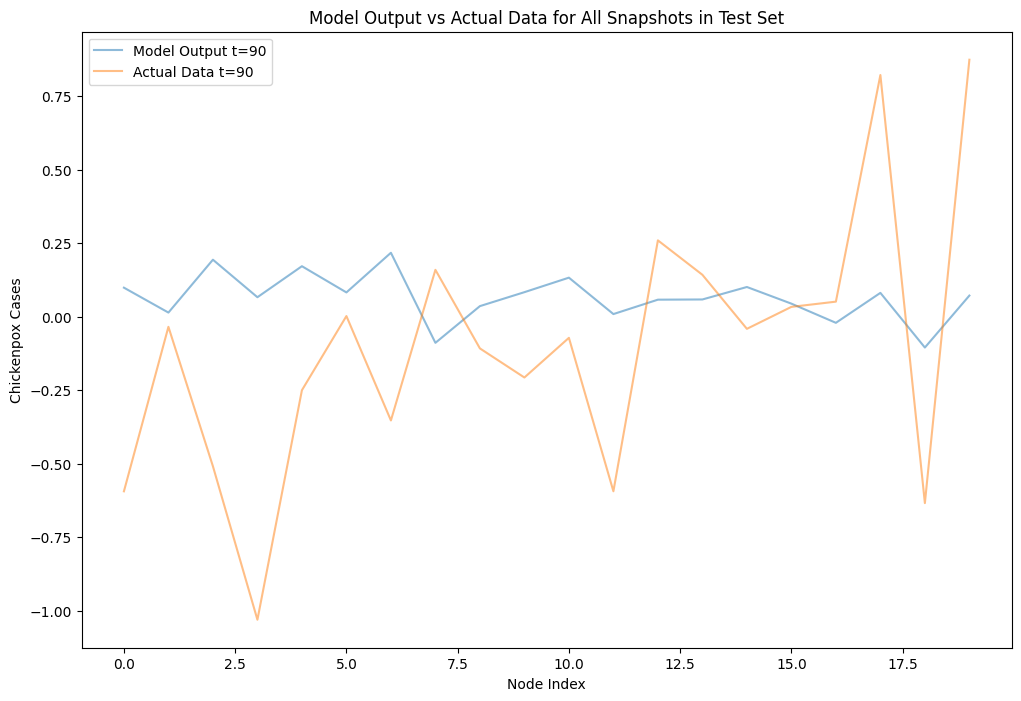

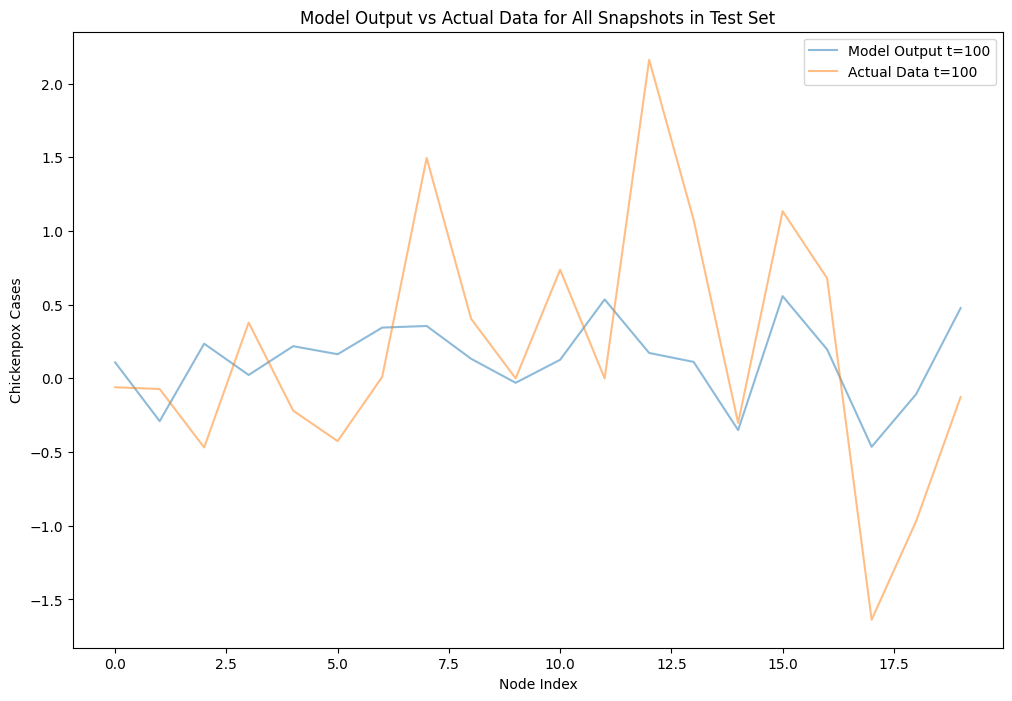

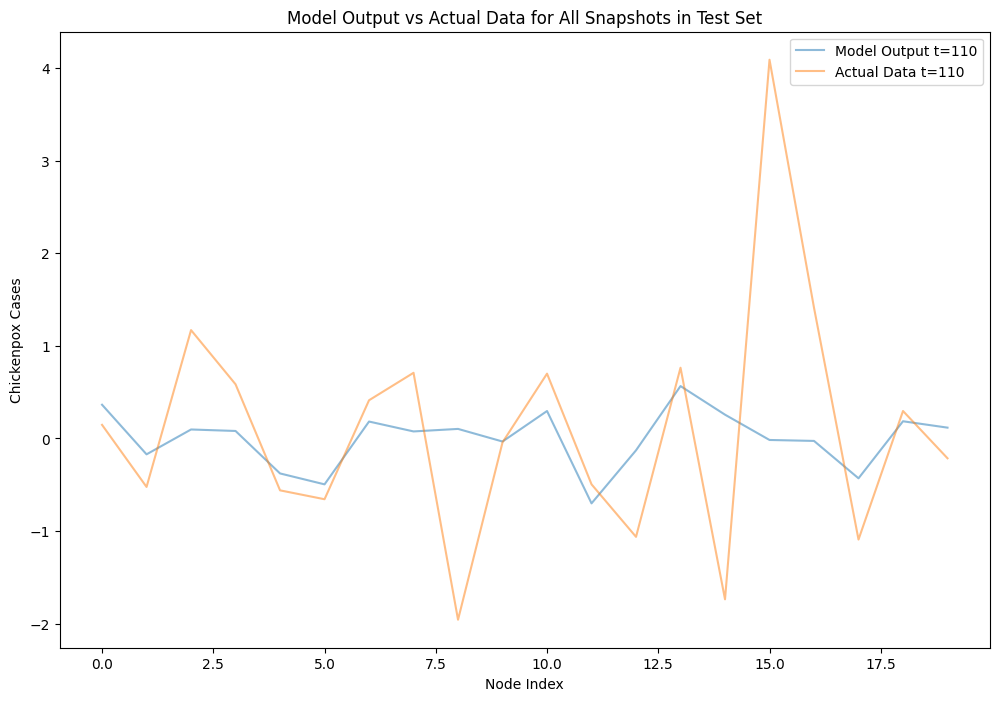

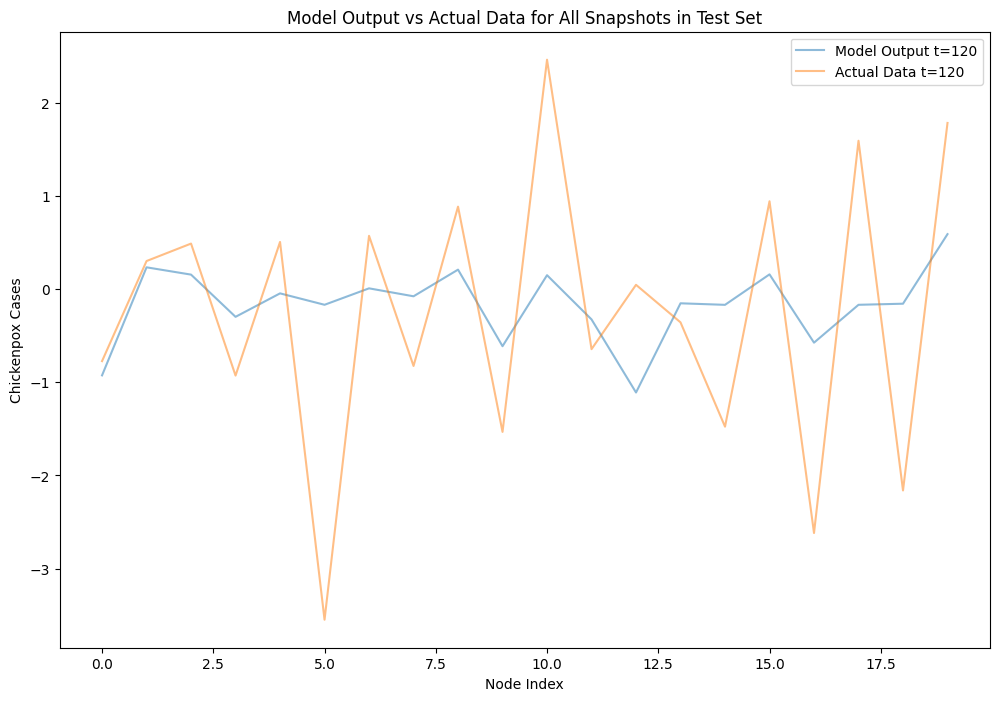

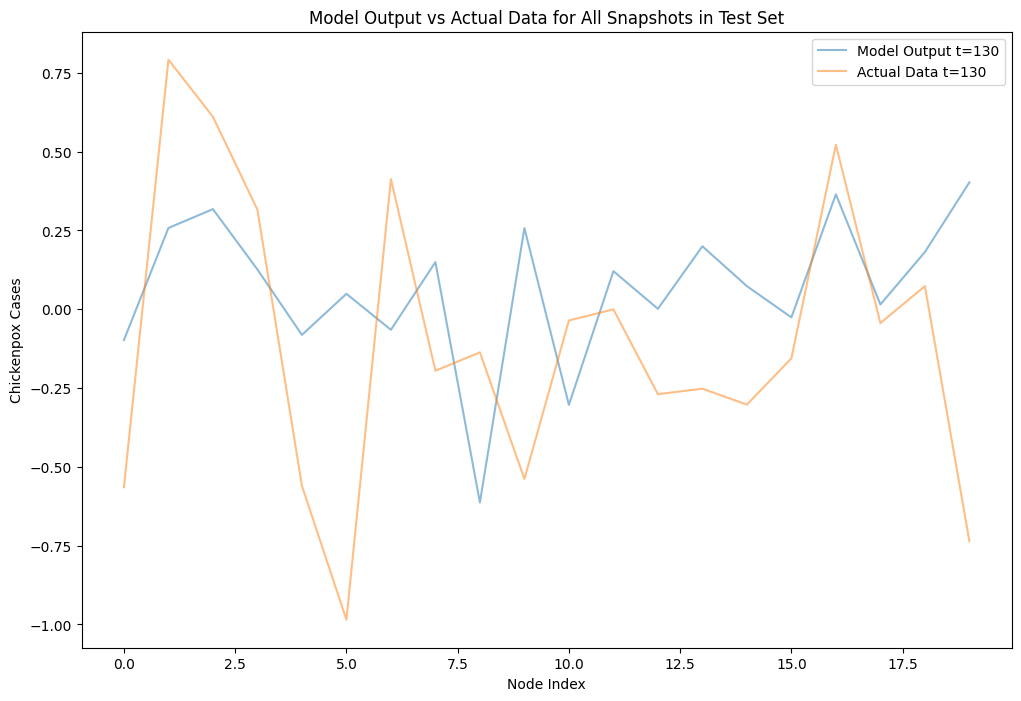

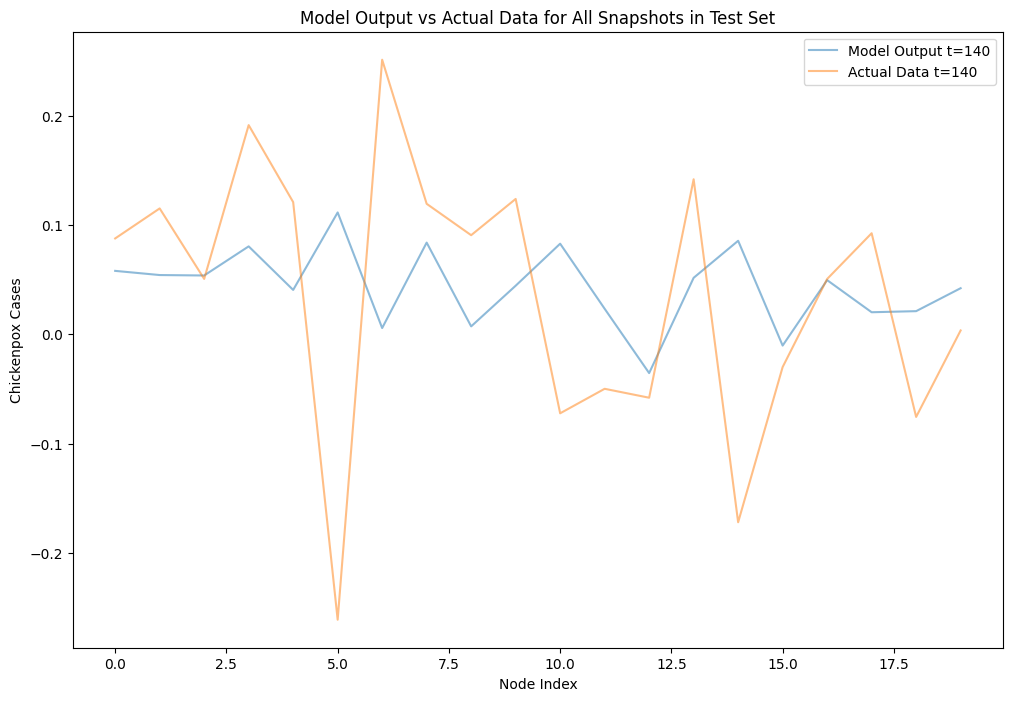

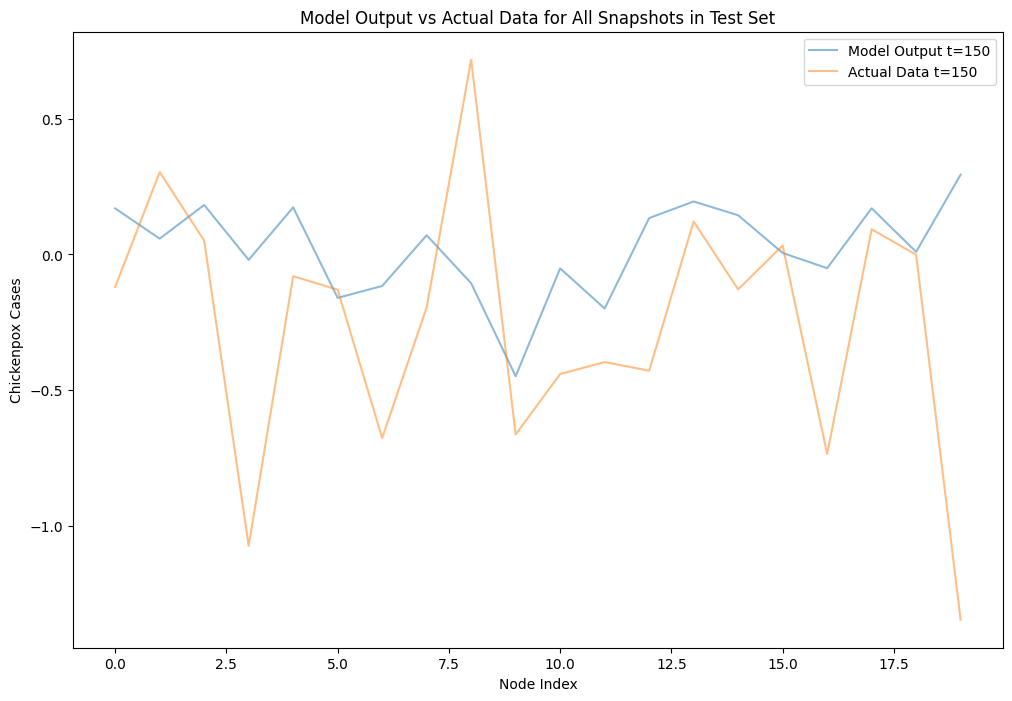

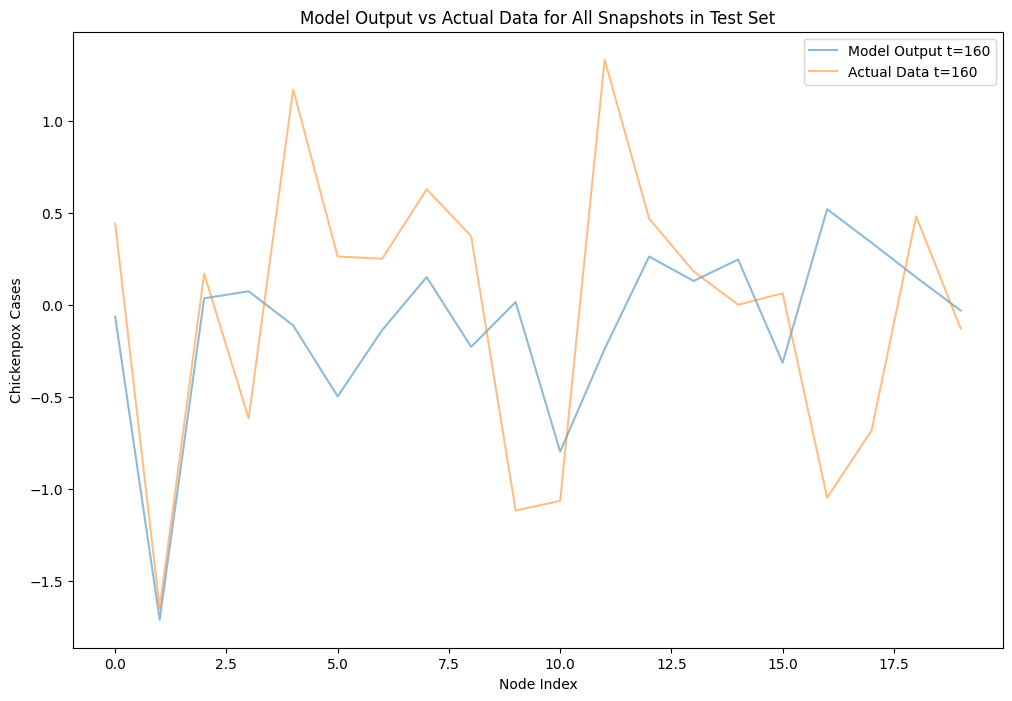

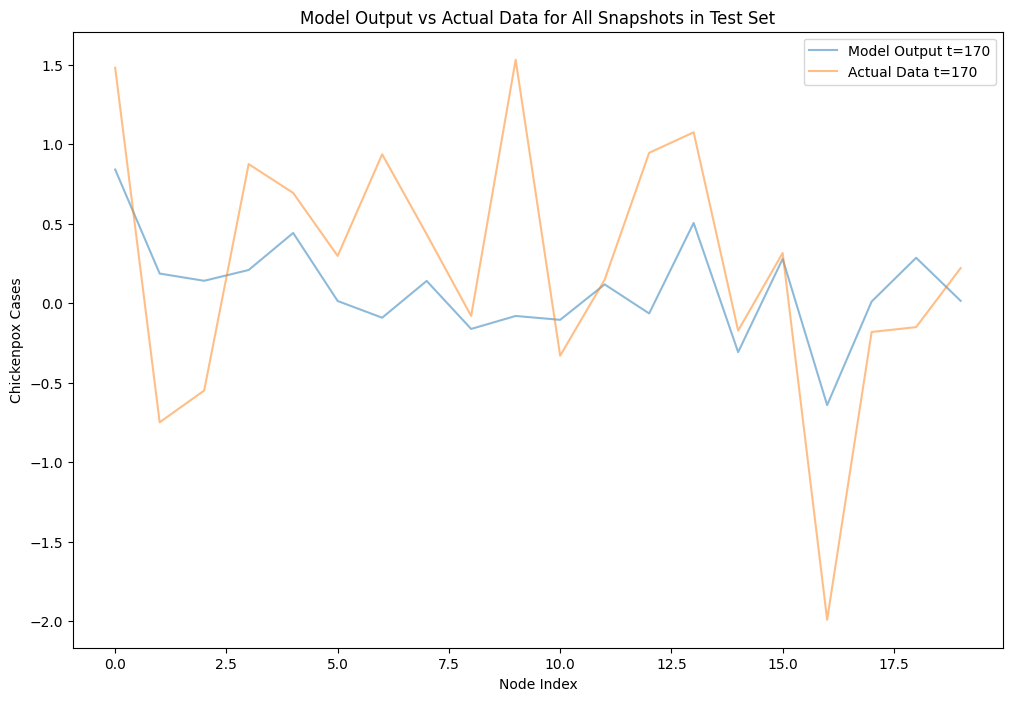

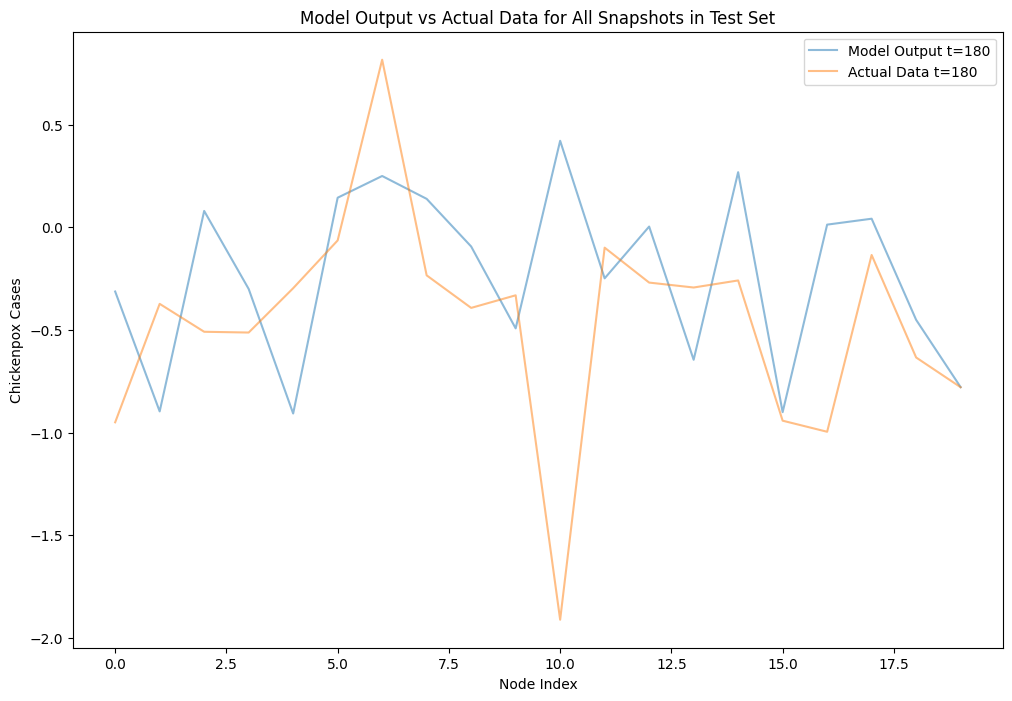

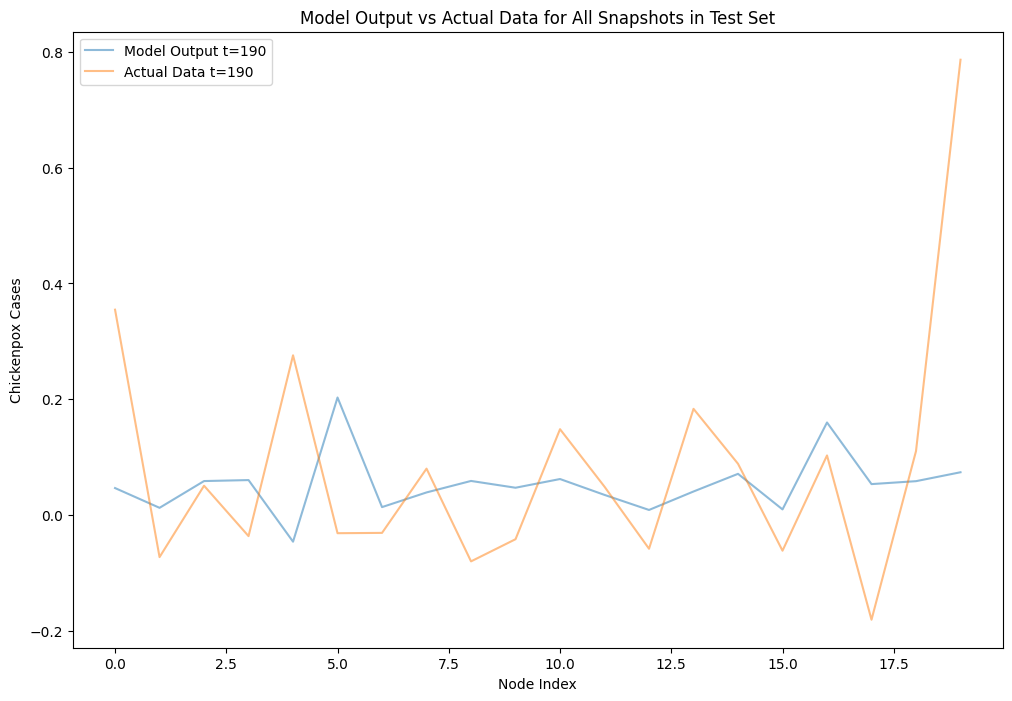

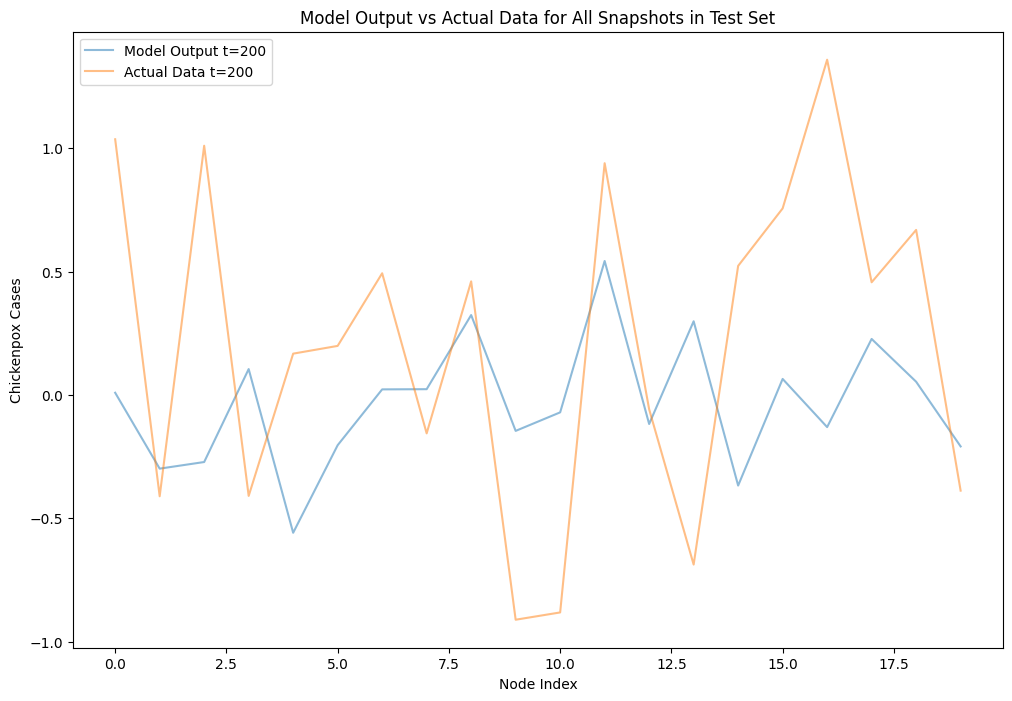

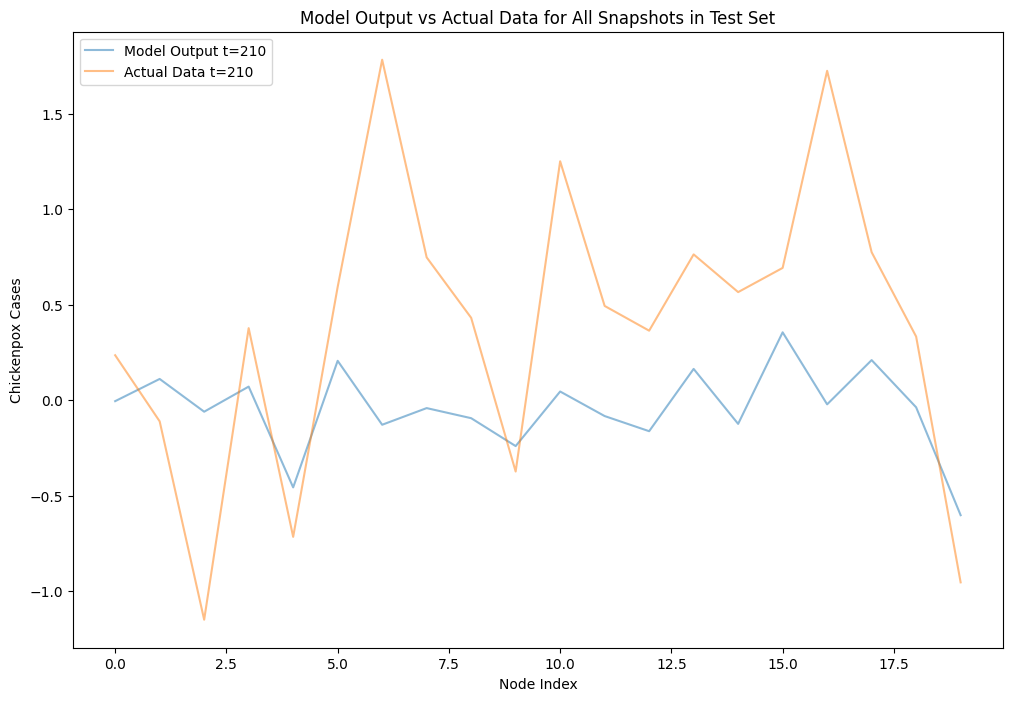

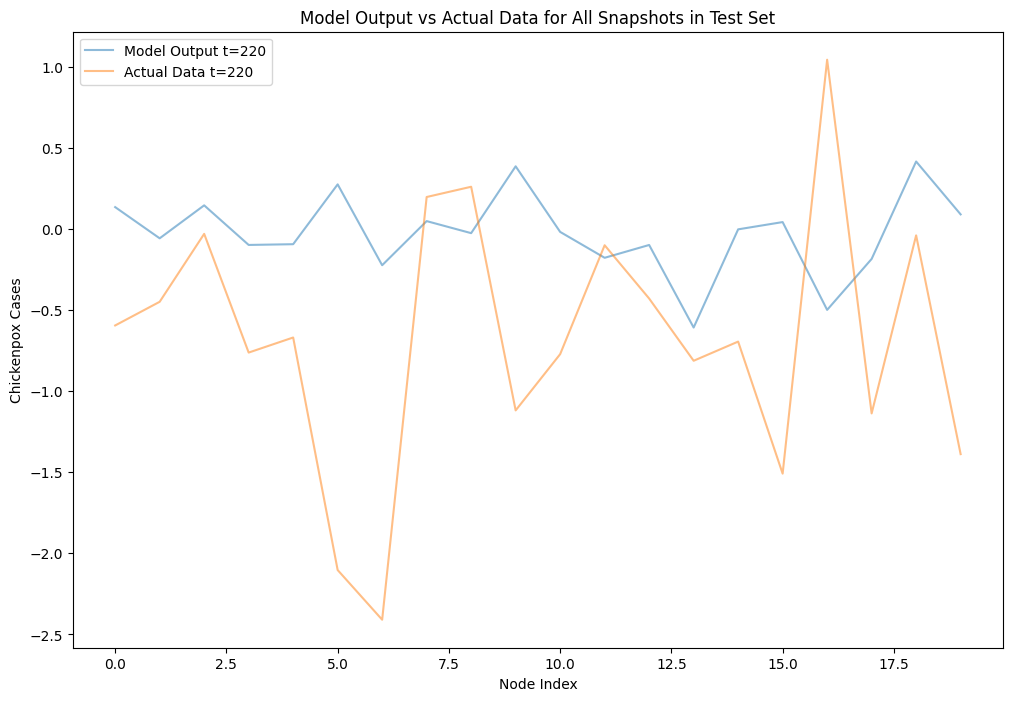

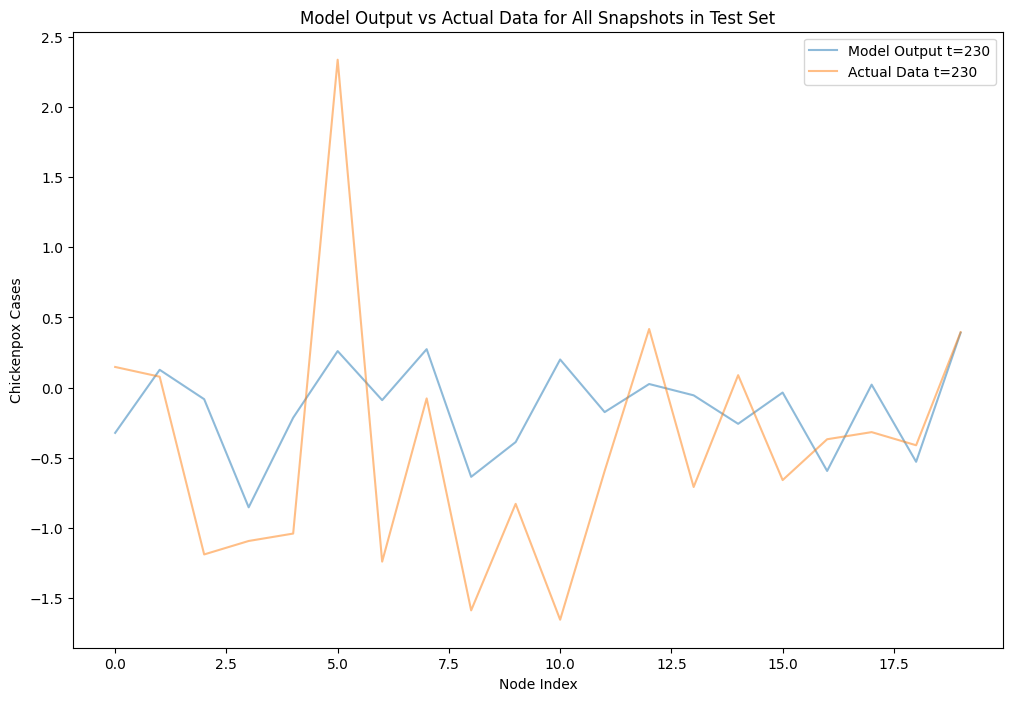

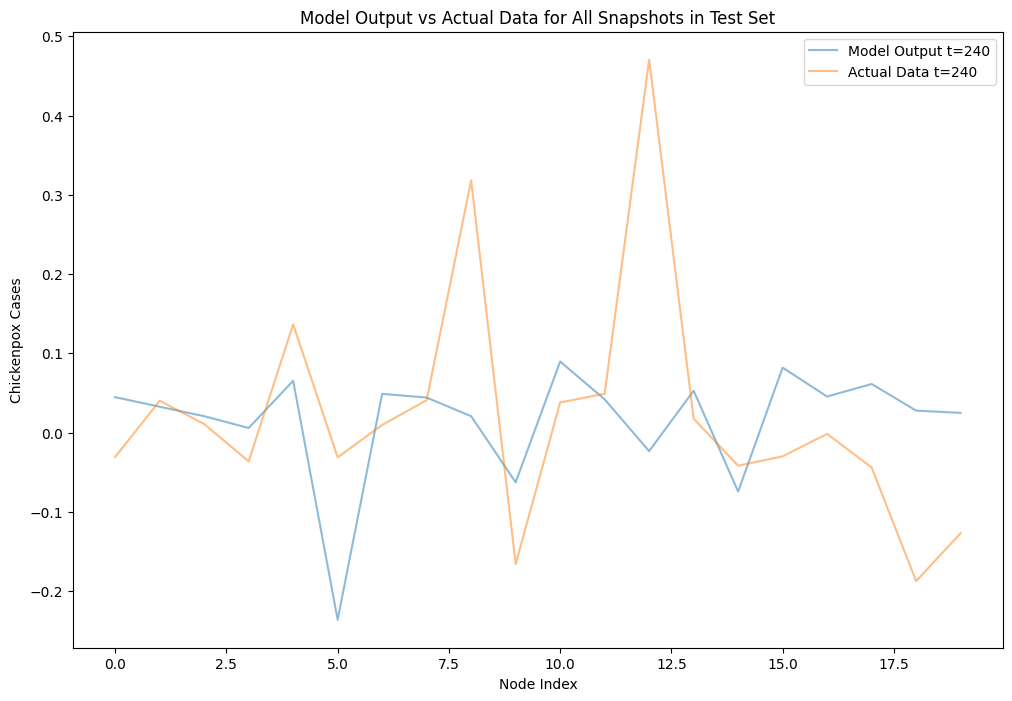

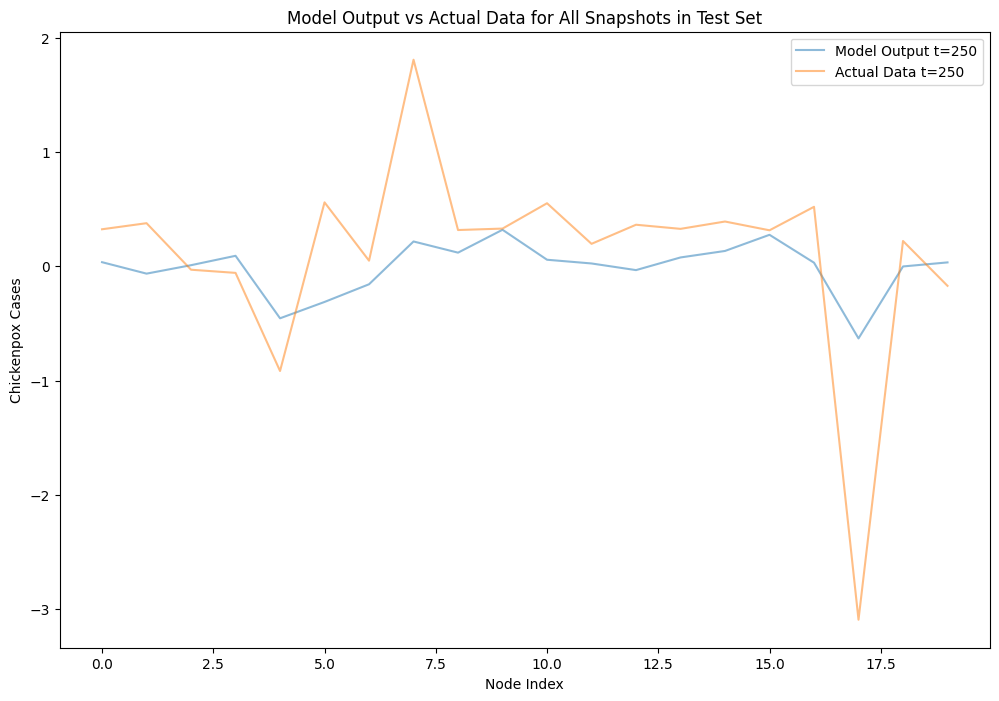

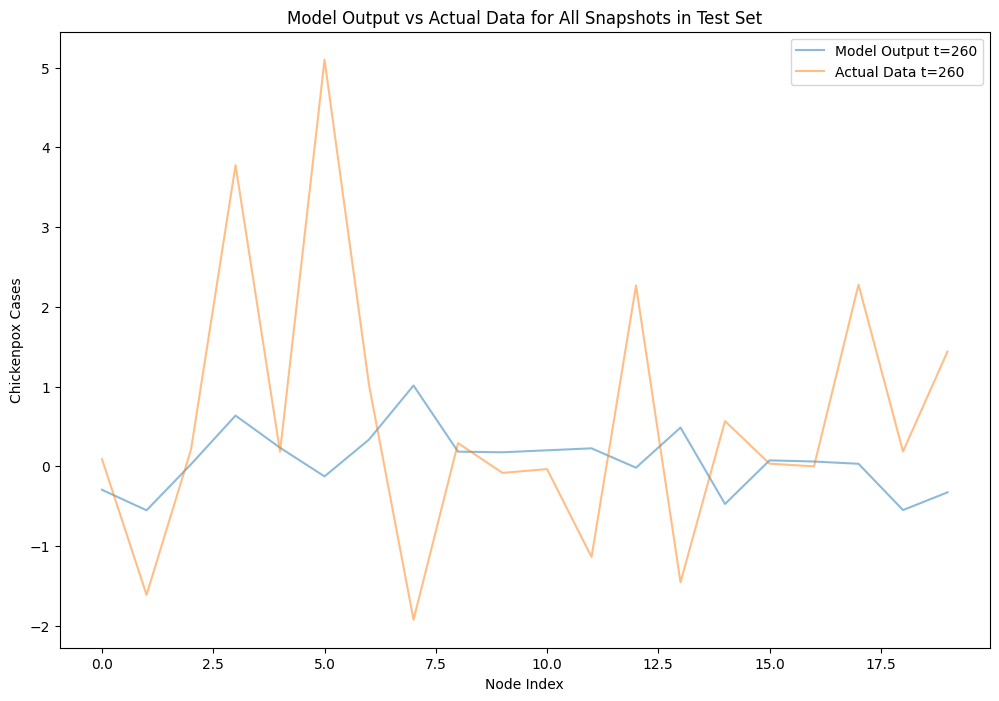

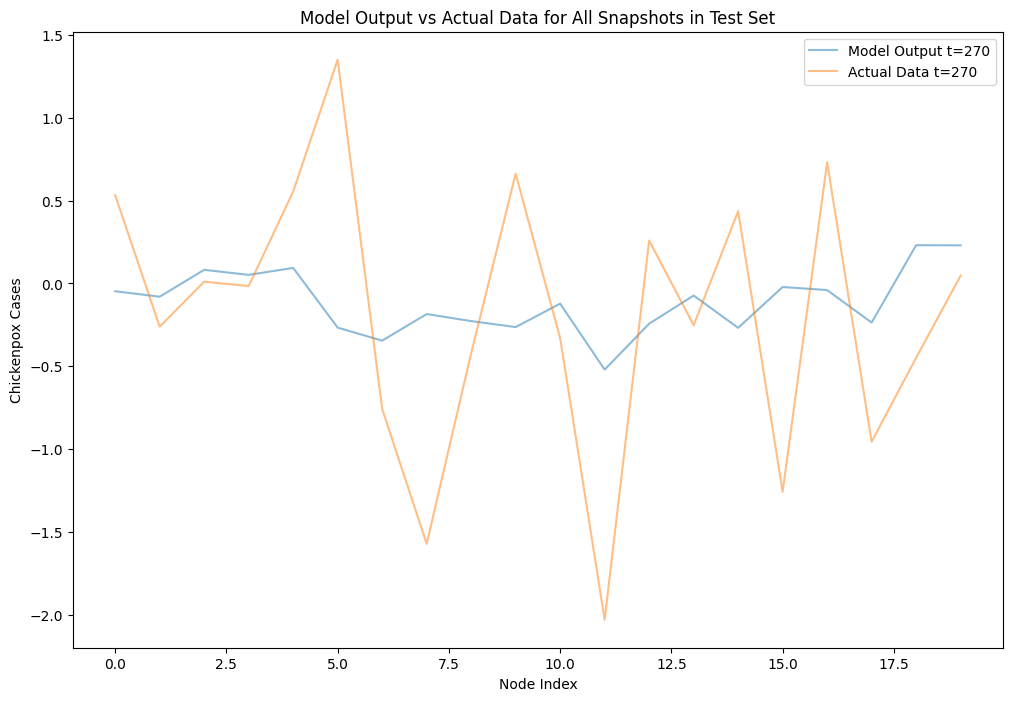

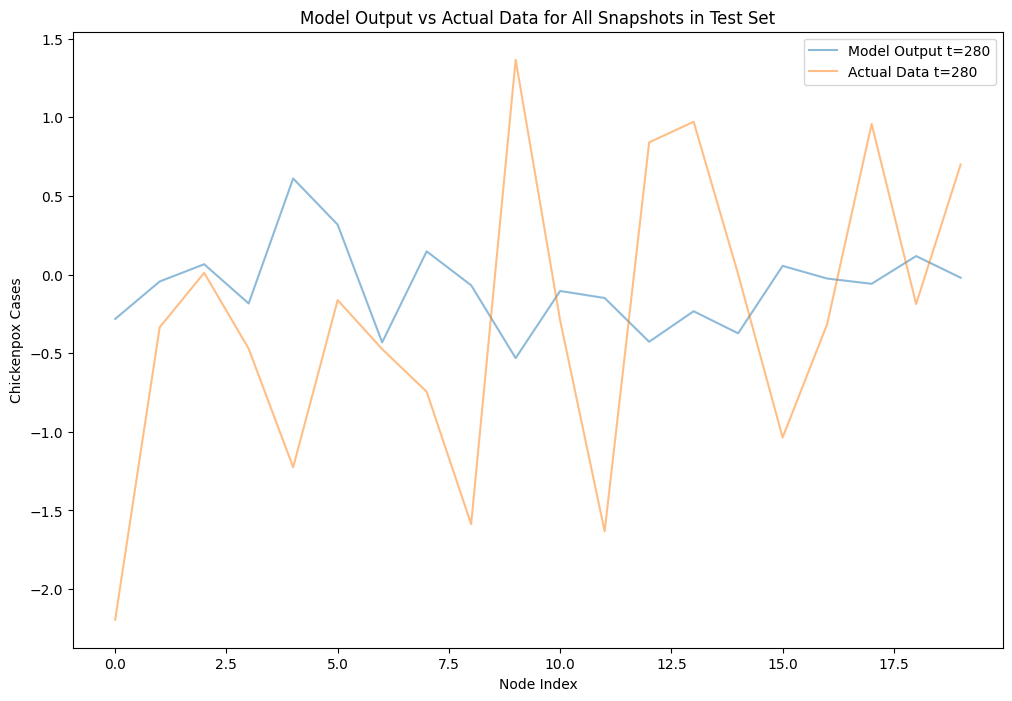

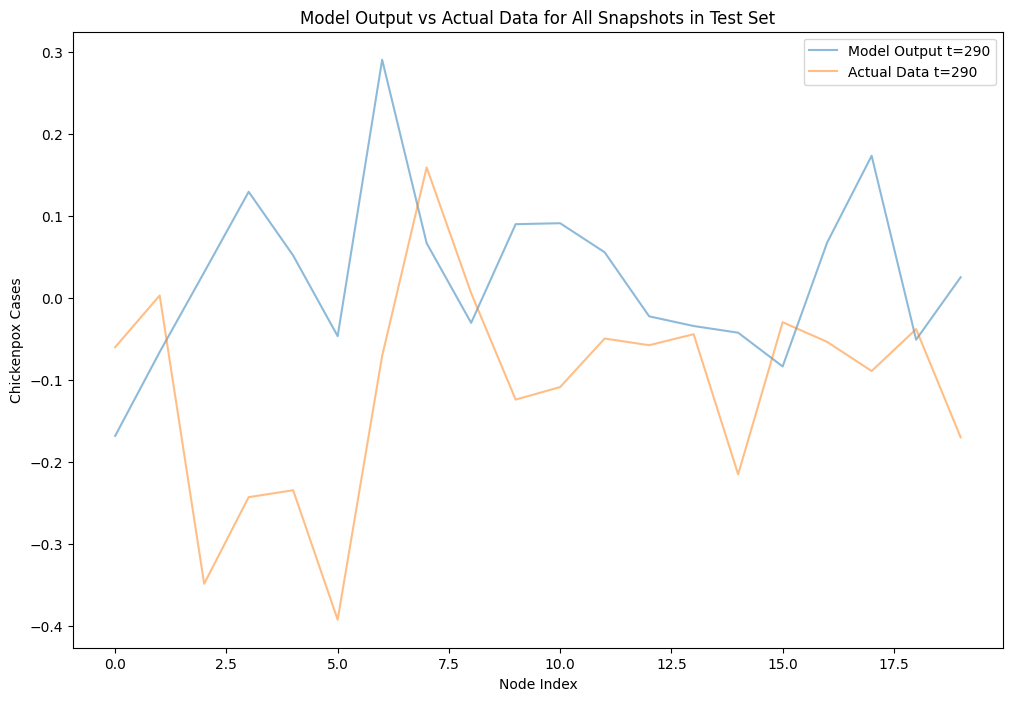

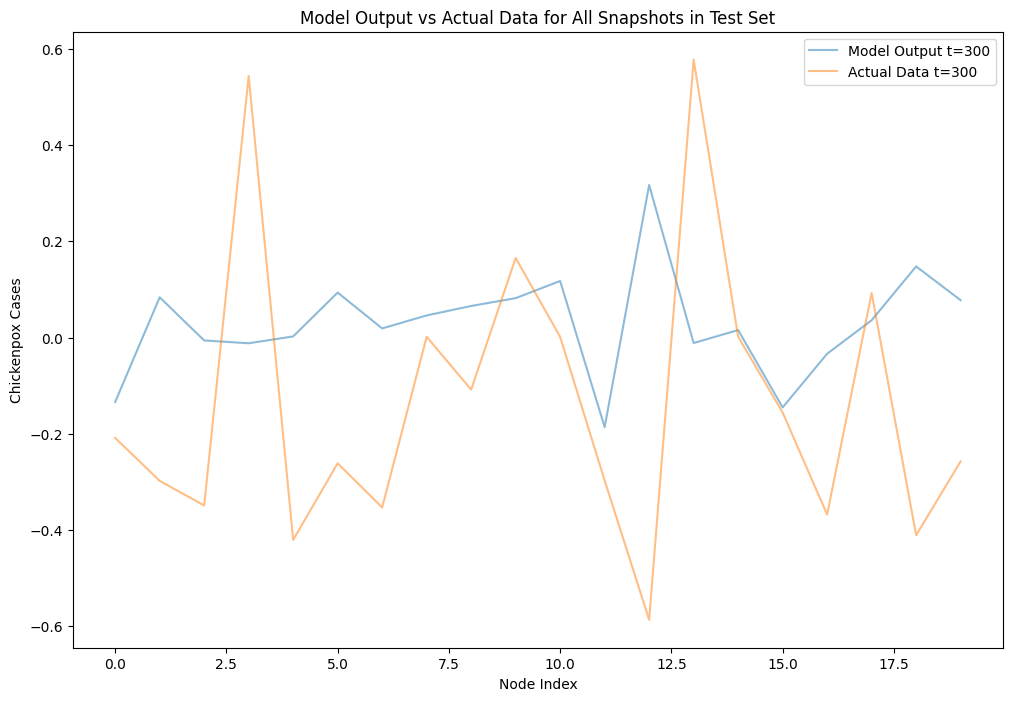

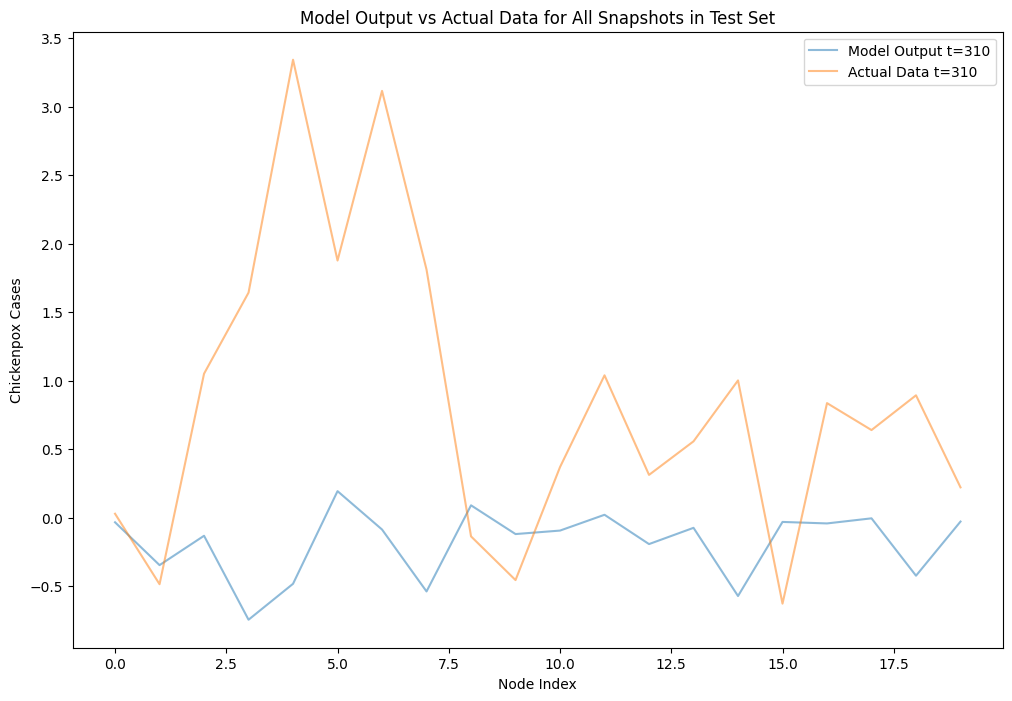

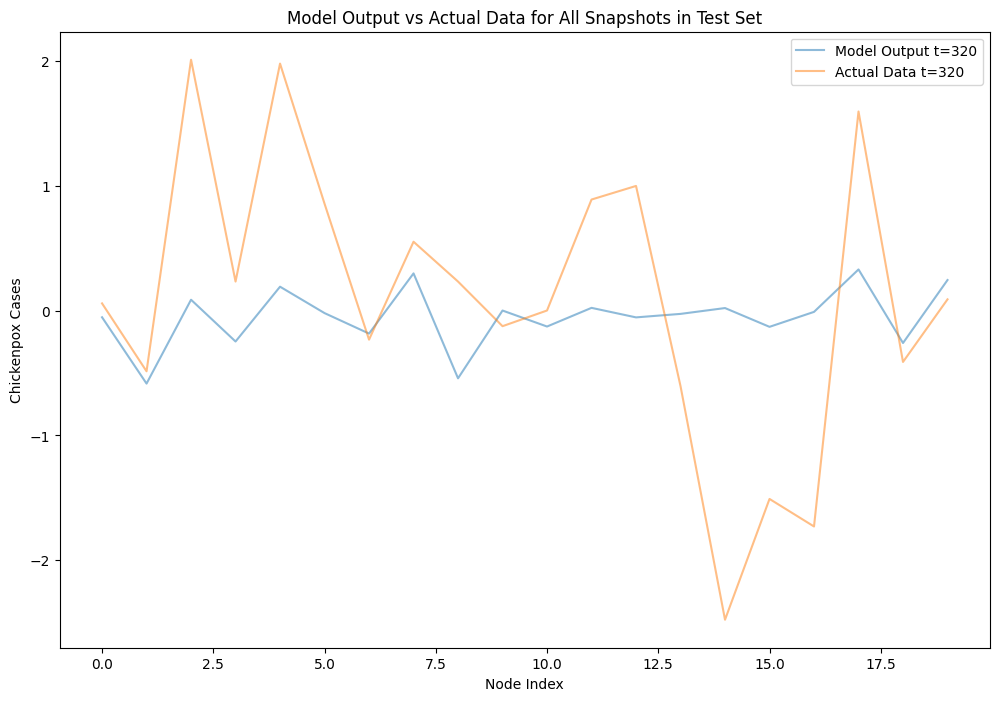

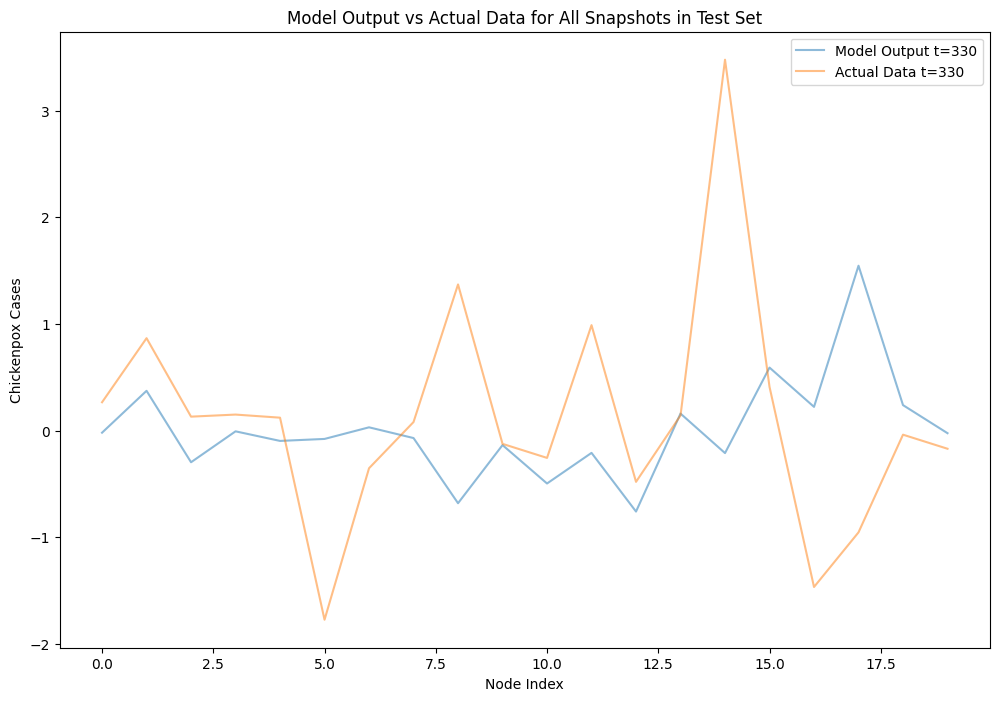

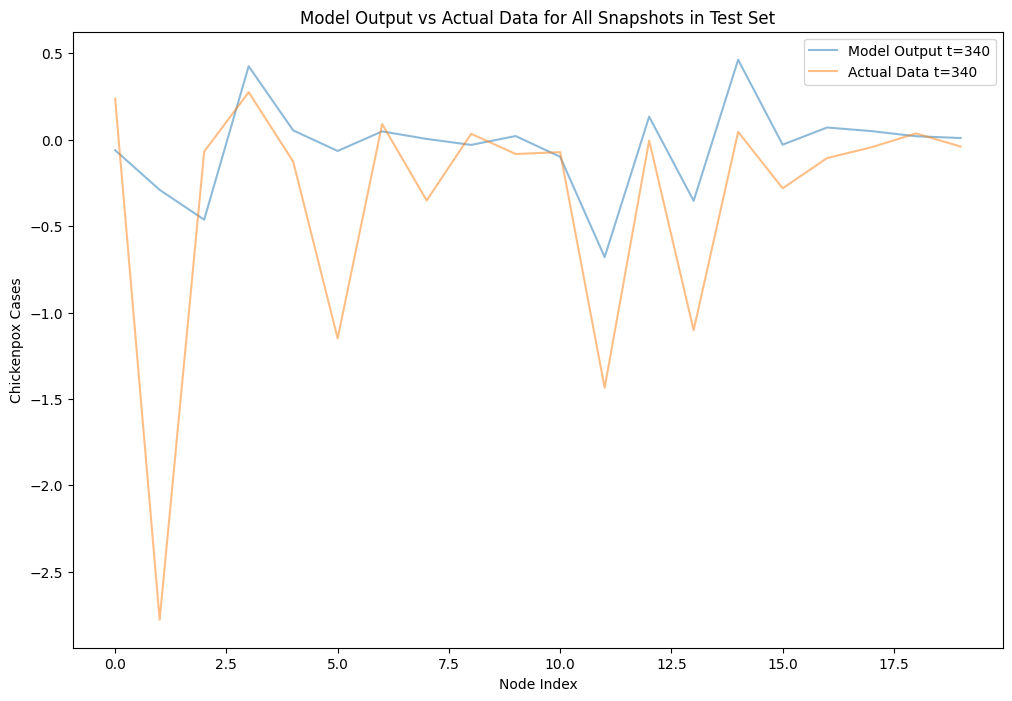

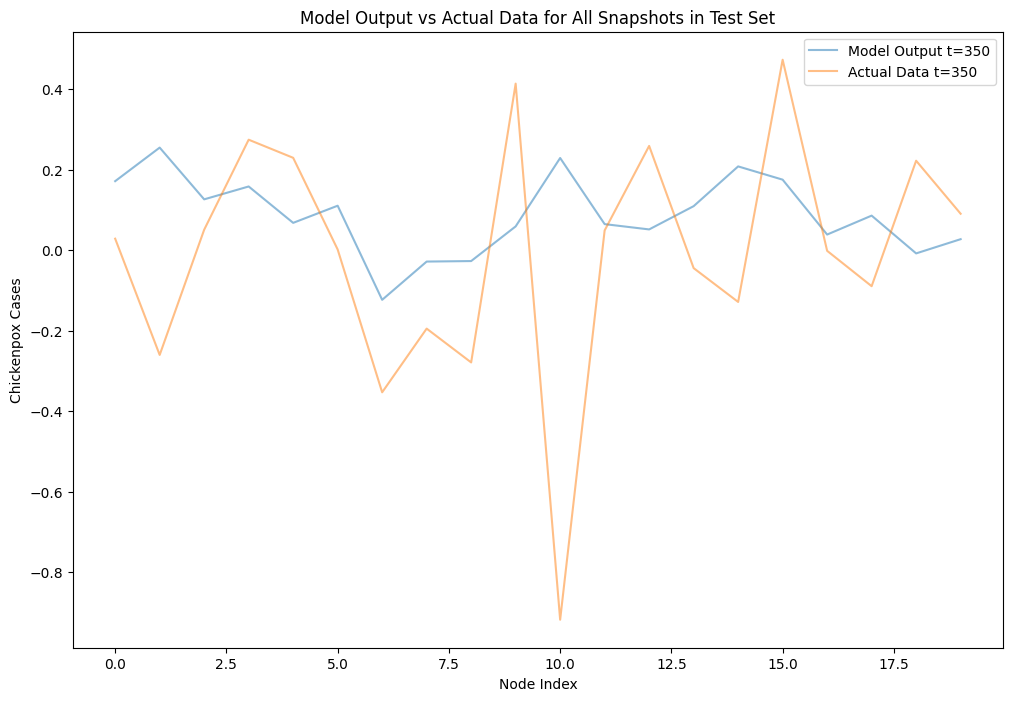

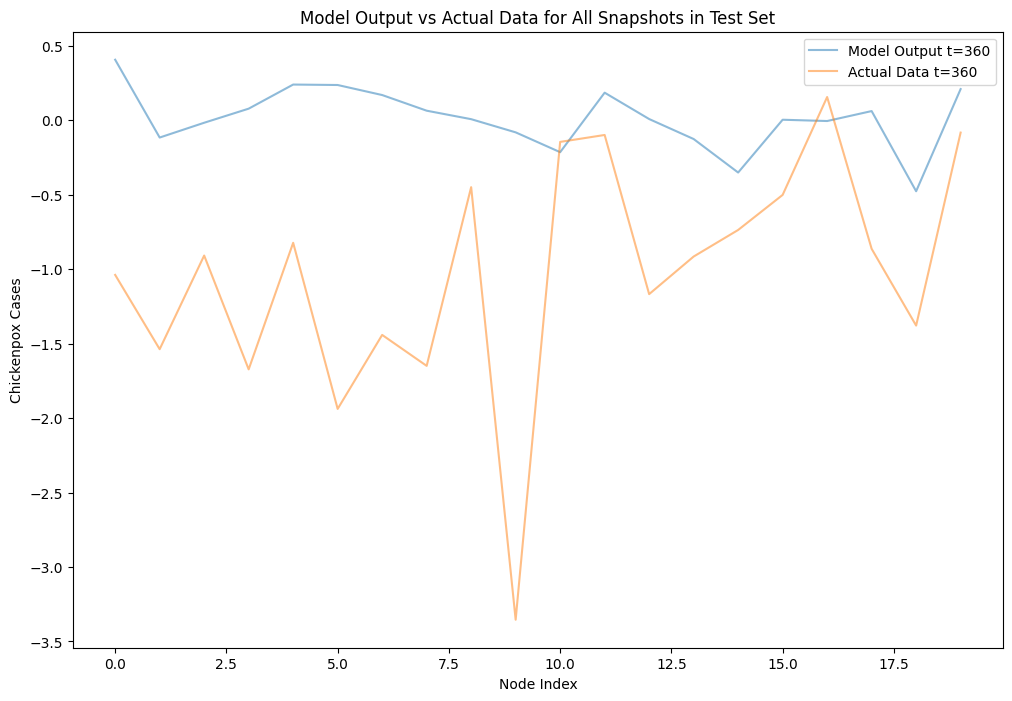

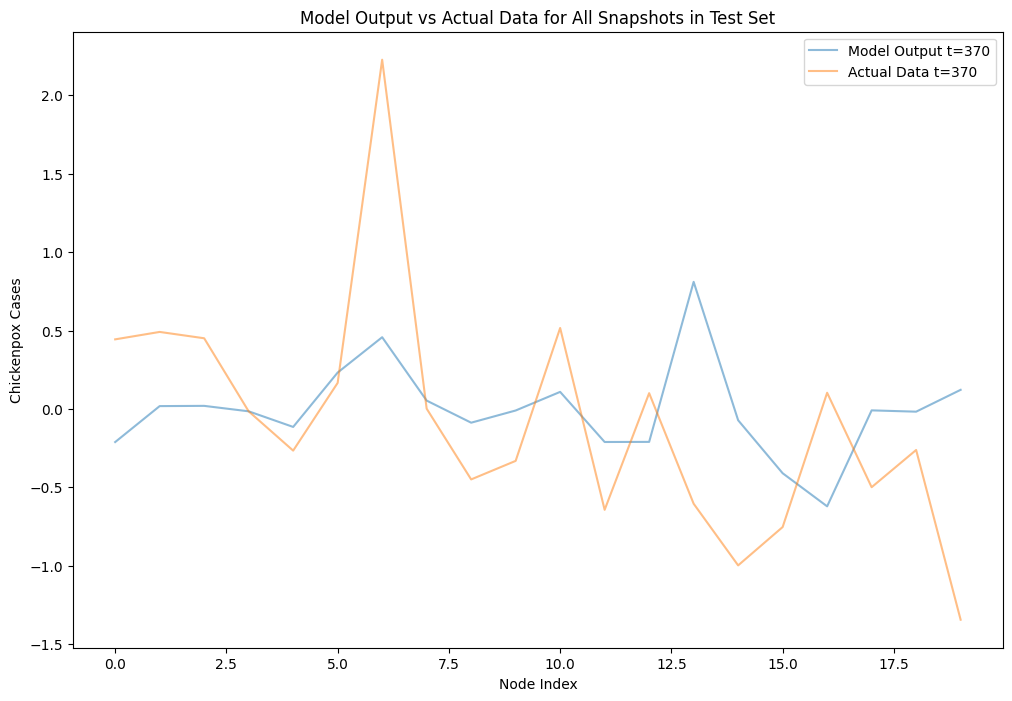

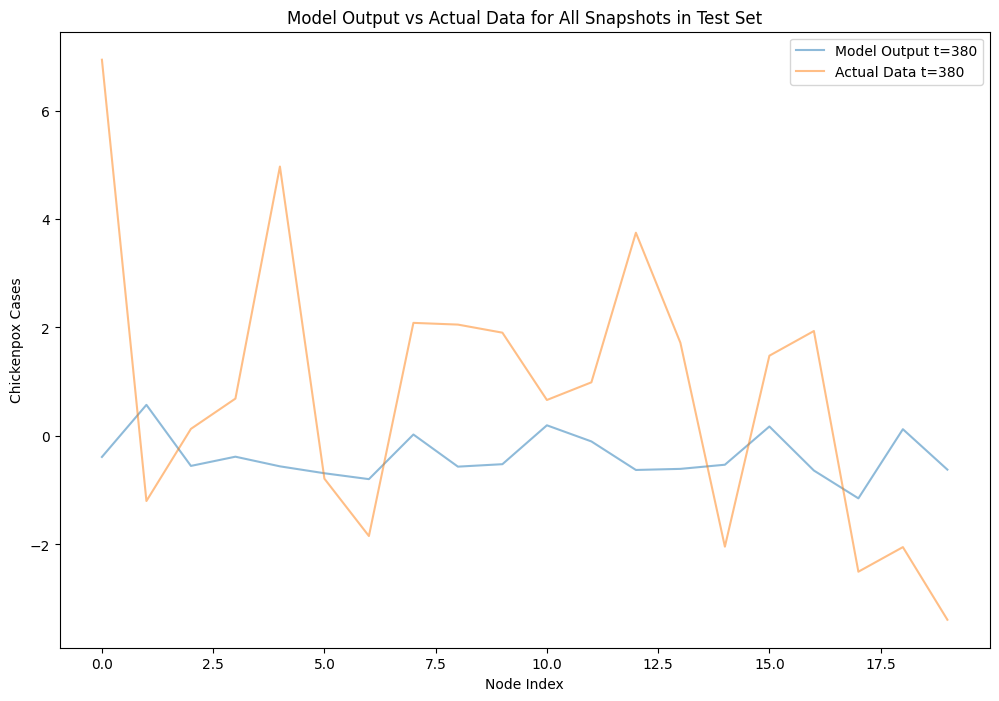

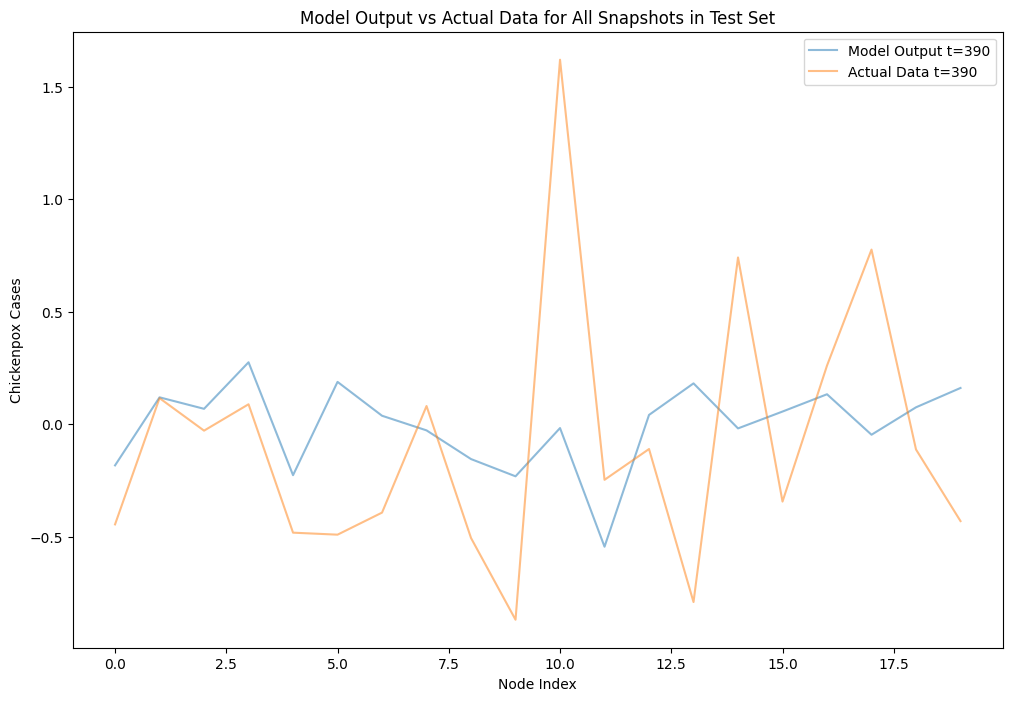

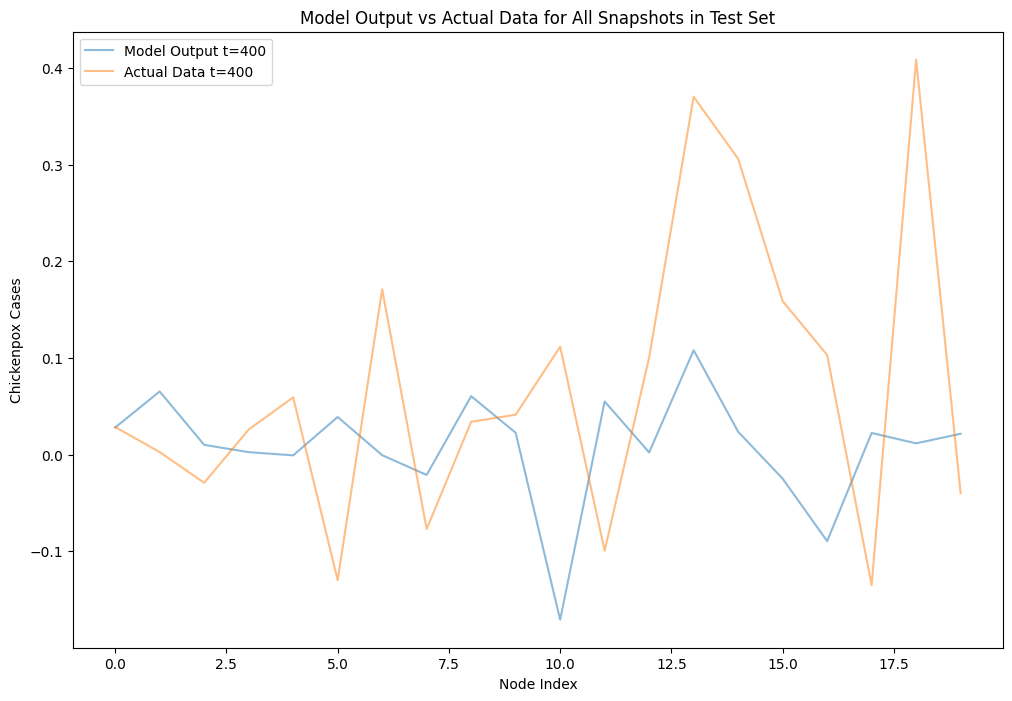

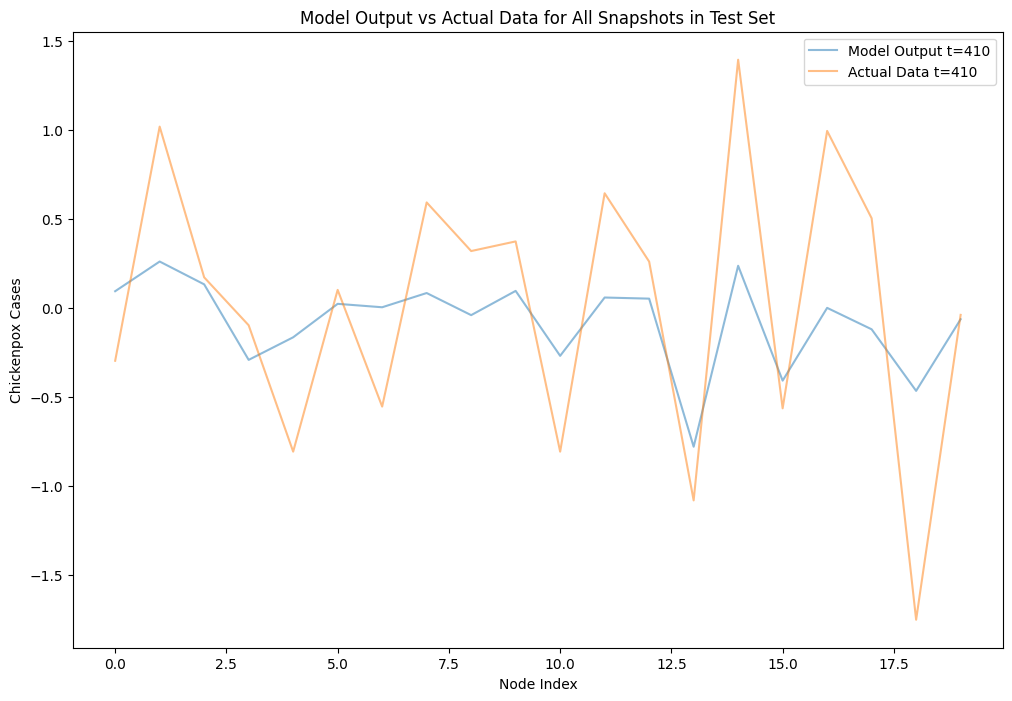

In [ ]:
# # Plot model output vs actual data for the last snapshot in the test set
# plt.figure(figsize=(10,6))
# plt.plot(y_hat.detach().cpu().numpy(), label='Model Output', marker='o')
# plt.plot(snapshot.y.detach().cpu().numpy(), label='Actual Data', marker='x')
# plt.xlabel('Node Index')
# plt.ylabel('Chickenpox Cases')
# plt.title('Model Output vs Actual Data')
# plt.legend()
# plt.show()

# Plot all snapshots in the test set

for time, snapshot in enumerate(test_dataset):
    if time % 10 != 0:
        continue  # Plot every 10th snapshot to reduce number of plots
    plt.figure(figsize=(12,8))
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    plt.plot(y_hat.detach().cpu().numpy(), label=f'Model Output t={time}', alpha=0.5)
    plt.plot(snapshot.y.detach().cpu().numpy(), label=f'Actual Data t={time}', alpha=0.5)
    plt.xlabel('Node Index')
    plt.ylabel('Chickenpox Cases')
    plt.title('Model Output vs Actual Data for All Snapshots in Test Set')
    plt.legend()
    plt.show()  